# Exploratory Data Analysis - Pairs Trading Research

**Date:** November 24, 2024  
**Author:** Research Project  
**Objective:** Explore and analyze pairs trading results

This notebook provides interactive exploration of:
- Stock price data and correlations
- Cointegrated pairs identification
- Trading signals and spread analysis
- Performance analysis and trade statistics

## 1. Setup and Data Loading

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from scipy import stats
from statsmodels.tsa.stattools import adfuller

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
%matplotlib inline

# Set figure defaults
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Load all data
prices = pd.read_csv('../data/processed/stock_prices.csv', index_col=0, parse_dates=True)
with open('../data/processed/metadata.json', 'r') as f:
    metadata = json.load(f)

# Load results
pairs_df = pd.read_csv('../results/cointegrated_pairs.csv')
is_trades = pd.read_csv('../results/is_trades.csv', parse_dates=['date', 'entry_date'])
oos_trades = pd.read_csv('../results/oos_trades.csv', parse_dates=['date', 'entry_date'])
is_metrics = pd.read_csv('../results/is_metrics.csv')
oos_metrics = pd.read_csv('../results/oos_metrics.csv')
is_returns = pd.read_csv('../results/is_daily_returns.csv', index_col=0, parse_dates=True)
oos_returns = pd.read_csv('../results/oos_daily_returns.csv', index_col=0, parse_dates=True)

print("✓ Data loaded successfully")
print(f"\nDataset shape: {prices.shape}")
print(f"Date range: {prices.index.min()} to {prices.index.max()}")
print(f"Cointegrated pairs: {len(pairs_df)}")

✓ Data loaded successfully

Dataset shape: (1760, 73)
Date range: 2018-01-02 00:00:00-05:00 to 2024-12-30 00:00:00-05:00
Cointegrated pairs: 10


## 2. Price Data Exploration

In [3]:
# Summary statistics
print("=" * 80)
print("PRICE DATA SUMMARY")
print("=" * 80)
print(prices.describe().T[['mean', 'std', 'min', 'max']].round(2))

PRICE DATA SUMMARY
        mean    std     min     max
ACGL   48.50  23.10   21.15  109.22
AFL    54.62  19.59   22.00  112.28
AIG    48.96  13.35   16.36   77.98
AIZ   128.13  33.99   72.83  225.29
AJG   144.83  69.43   55.68  312.64
...      ...    ...     ...     ...
V     199.37  47.23  107.72  318.65
WFC    41.56   9.80   18.75   75.70
WRB    33.62  11.81   17.06   63.65
WTW   202.21  42.65  122.61  328.81
XYZ   101.33  63.53   36.17  281.81

[73 rows x 4 columns]


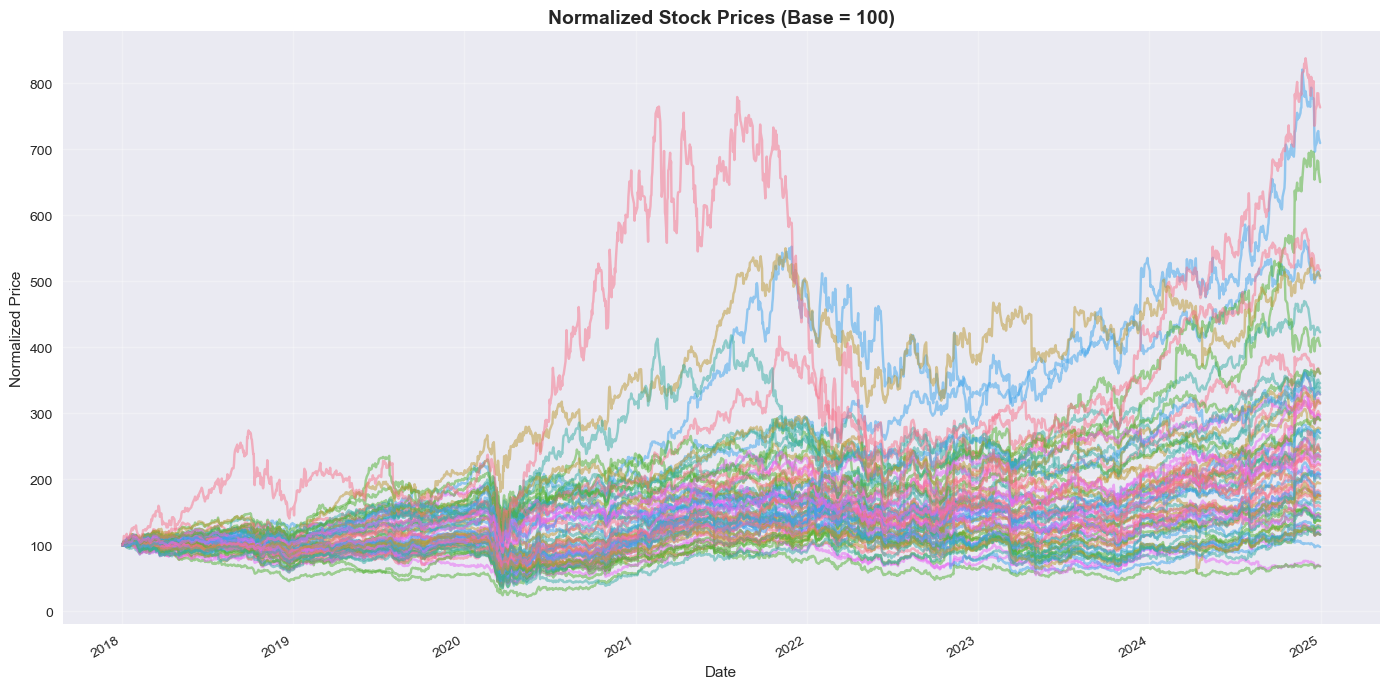

In [4]:
# Plot normalized prices for all stocks
fig, ax = plt.subplots(figsize=(14, 7))
normalized = prices / prices.iloc[0] * 100
normalized.plot(ax=ax, alpha=0.5, legend=False)
ax.set_title('Normalized Stock Prices (Base = 100)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Price')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

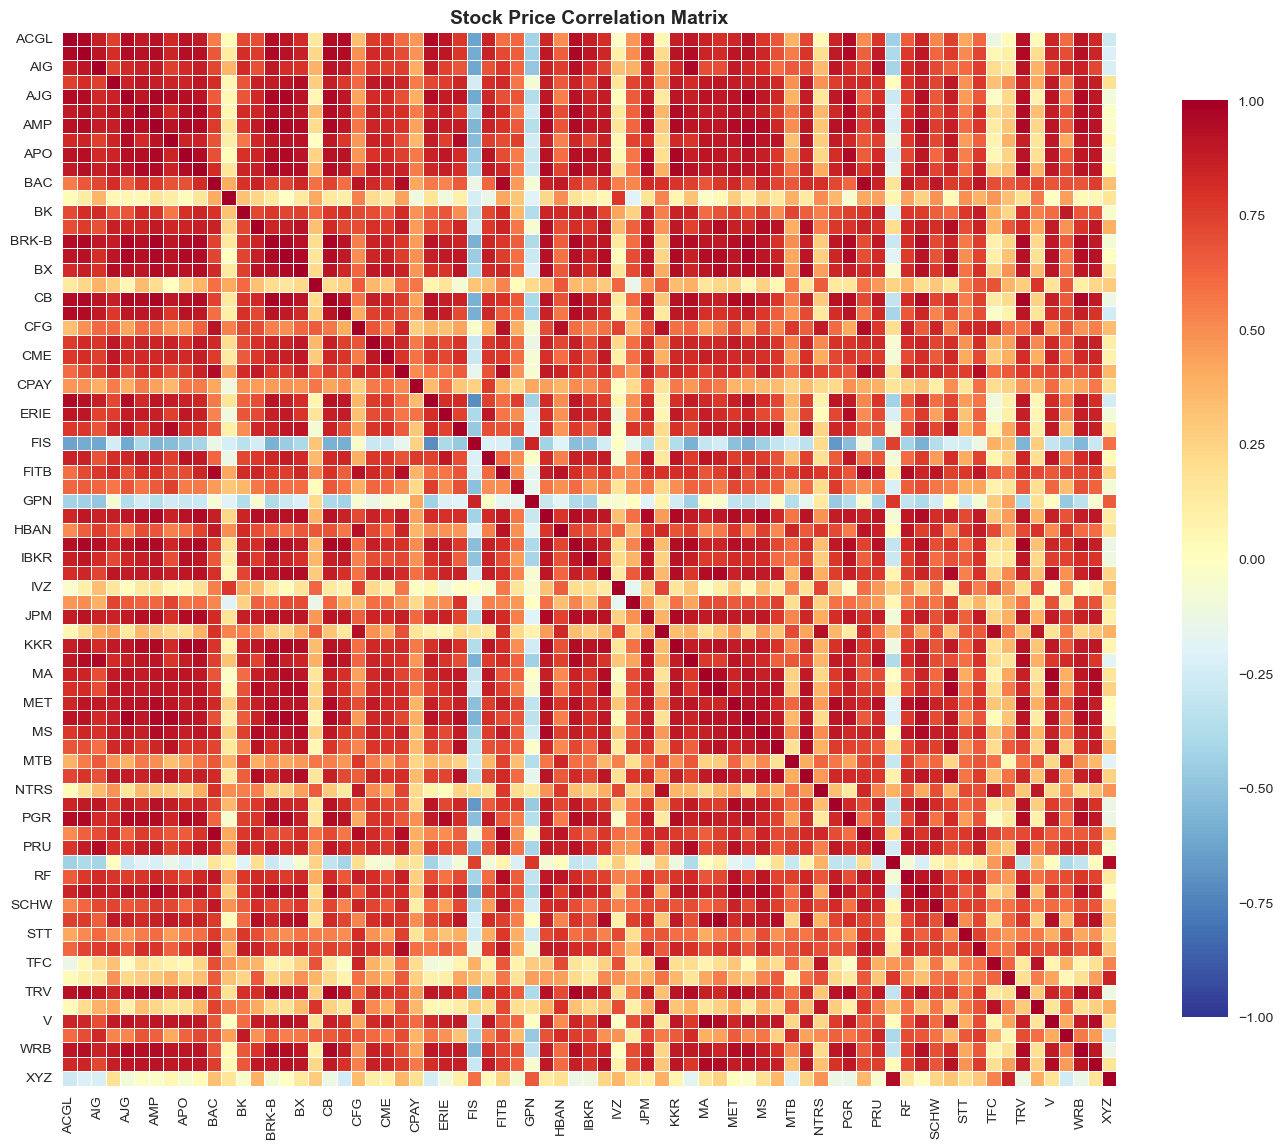


=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
TOP 10 HIGHEST CORRELATIONS (excluding diagonal)
     Stock1 Stock2  Correlation
2245     MA      V     0.993650
324     AJG    MMC     0.990179
2265    MCO   SPGI     0.988891
1190     CB    TRV     0.982019
424     AMP  BRK-B     0.979789
719     BAC    PNC     0.978596
1749   FITB    PNC     0.978498
920   BRK-B     CB     0.977269
1955    HIG    TRV     0.976774
1159     CB    HIG     0.976065


In [5]:
# Correlation heatmap
fig, ax = plt.subplots(figsize=(14, 12))
corr_matrix = prices.corr()
sns.heatmap(corr_matrix, cmap='RdYlBu_r', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            ax=ax, vmin=-1, vmax=1)
ax.set_title('Stock Price Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highest correlations
print("\n=" * 80)
print("TOP 10 HIGHEST CORRELATIONS (excluding diagonal)")
print("=" * 80)
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append((
            corr_matrix.columns[i],
            corr_matrix.columns[j],
            corr_matrix.iloc[i, j]
        ))
corr_pairs_df = pd.DataFrame(corr_pairs, columns=['Stock1', 'Stock2', 'Correlation'])
print(corr_pairs_df.nlargest(10, 'Correlation'))

## 3. Cointegrated Pairs Analysis

In [6]:
# Display pairs information
print("=" * 80)
print(f"IDENTIFIED COINTEGRATED PAIRS: {len(pairs_df)}")
print("=" * 80)
for idx, row in pairs_df.iterrows():
    print(f"\nPair {idx + 1}: {row['ticker1']} - {row['ticker2']}")
    print(f"  Correlation: {row['correlation']:.4f}")
    print(f"  ADF Statistic: {row['adf_statistic']:.4f}")
    print(f"  P-value: {row['p_value']:.6f}")
    print(f"  Hedge Ratio: {row['hedge_ratio']:.4f}")
    print(f"  Half-life: {row['half_life']:.2f} days")
    print(f"  Spread Std: {row['spread_std']:.6f}")

IDENTIFIED COINTEGRATED PAIRS: 10

Pair 1: NTRS - TFC
  Correlation: 0.7874
  ADF Statistic: -4.5725
  P-value: 0.000145
  Hedge Ratio: 0.7972
  Half-life: 25.25 days
  Spread Std: 0.056940

Pair 2: BAC - PNC
  Correlation: 0.8834
  ADF Statistic: -4.5249
  P-value: 0.000177
  Hedge Ratio: 0.9332
  Half-life: 21.44 days
  Spread Std: 0.040985

Pair 3: SYF - TFC
  Correlation: 0.7702
  ADF Statistic: -4.5199
  P-value: 0.000181
  Hedge Ratio: 1.4145
  Half-life: 28.10 days
  Spread Std: 0.099900

Pair 4: COF - NTRS
  Correlation: 0.7491
  ADF Statistic: -4.4009
  P-value: 0.000296
  Hedge Ratio: 1.8295
  Half-life: 22.84 days
  Spread Std: 0.105249

Pair 5: MA - V
  Correlation: 0.9179
  ADF Statistic: -4.3195
  P-value: 0.000411
  Hedge Ratio: 1.2130
  Half-life: 15.42 days
  Spread Std: 0.030130

Pair 6: AIG - L
  Correlation: 0.7744
  ADF Statistic: -4.3098
  P-value: 0.000427
  Hedge Ratio: 1.3731
  Half-life: 31.01 days
  Spread Std: 0.087262

Pair 7: NTRS - SYF
  Correlation: 0.70

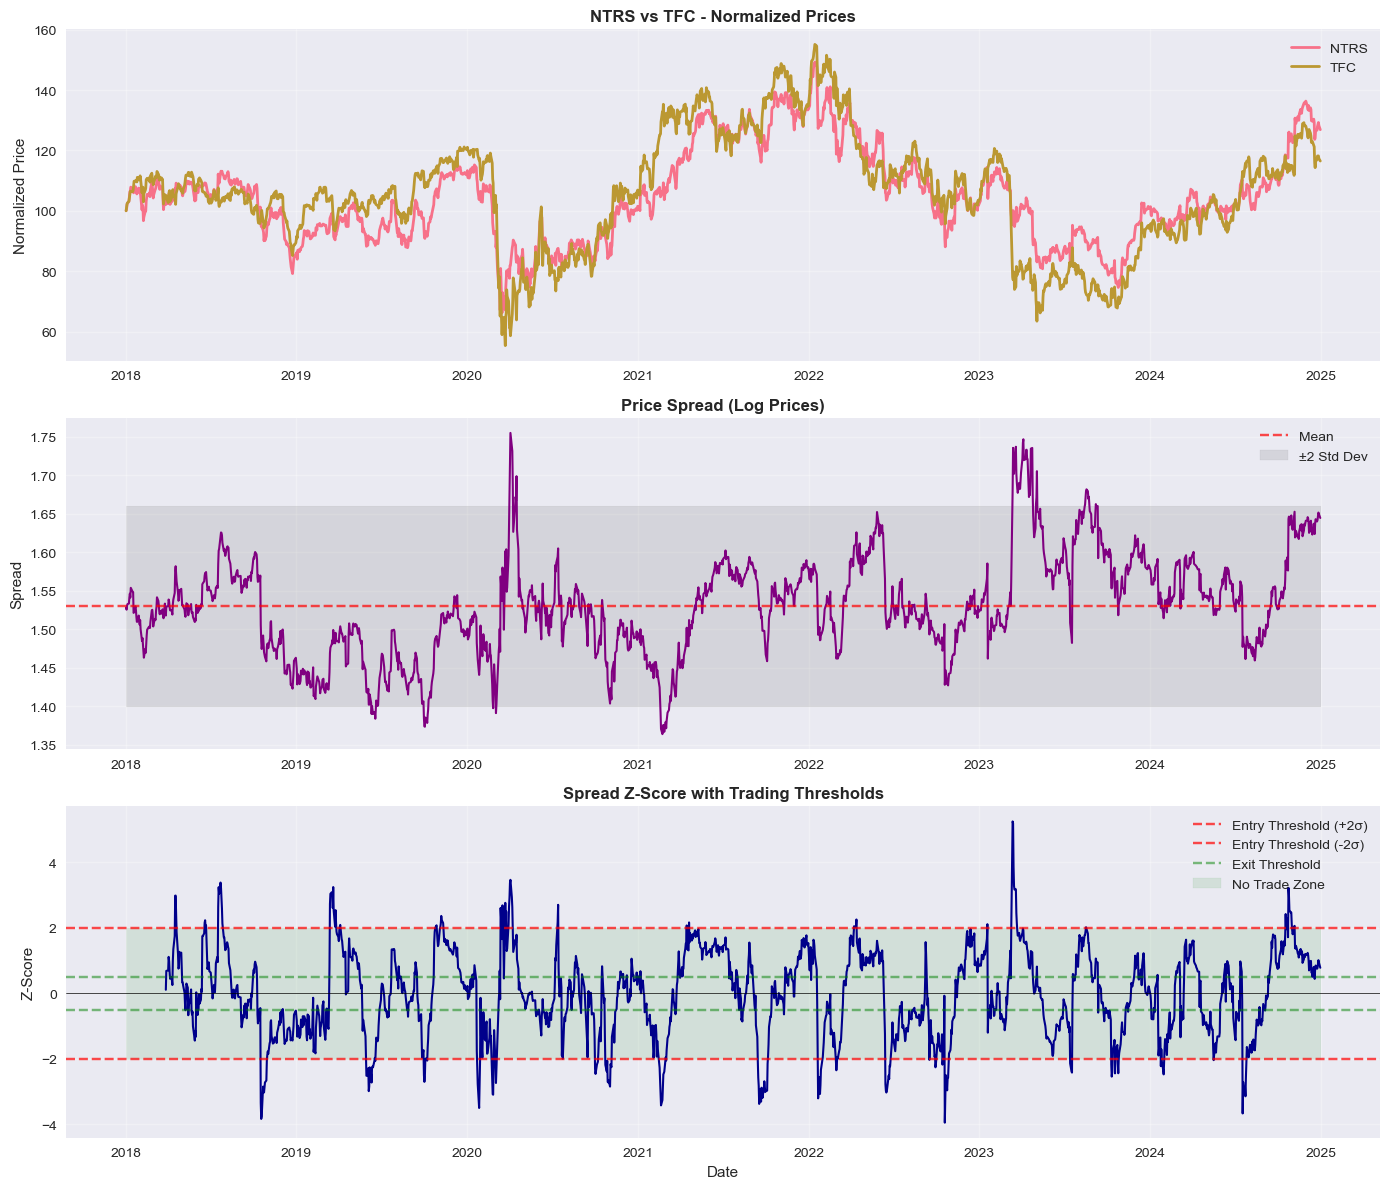

In [7]:
# Analyze the WFC-USB pair in detail
ticker1 = pairs_df.iloc[0]['ticker1']
ticker2 = pairs_df.iloc[0]['ticker2']
hedge_ratio = pairs_df.iloc[0]['hedge_ratio']

# Get prices
price1 = prices[ticker1]
price2 = prices[ticker2]

# Calculate spread
spread = np.log(price1) - hedge_ratio * np.log(price2)
zscore = (spread - spread.rolling(60).mean()) / spread.rolling(60).std()

# Plot pair analysis
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Normalized prices
axes[0].plot(price1.index, price1 / price1.iloc[0] * 100, label=ticker1, linewidth=2)
axes[0].plot(price2.index, price2 / price2.iloc[0] * 100, label=ticker2, linewidth=2)
axes[0].set_title(f'{ticker1} vs {ticker2} - Normalized Prices', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Normalized Price')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Spread
axes[1].plot(spread.index, spread, color='purple', linewidth=1.5)
axes[1].axhline(spread.mean(), color='red', linestyle='--', label='Mean', alpha=0.7)
axes[1].fill_between(spread.index, 
                     spread.mean() - 2*spread.std(), 
                     spread.mean() + 2*spread.std(), 
                     alpha=0.2, color='gray', label='±2 Std Dev')
axes[1].set_title('Price Spread (Log Prices)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Spread')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Z-score
axes[2].plot(zscore.index, zscore, color='darkblue', linewidth=1.5)
axes[2].axhline(2, color='red', linestyle='--', label='Entry Threshold (+2σ)', alpha=0.7)
axes[2].axhline(-2, color='red', linestyle='--', label='Entry Threshold (-2σ)', alpha=0.7)
axes[2].axhline(0.5, color='green', linestyle='--', label='Exit Threshold', alpha=0.5)
axes[2].axhline(-0.5, color='green', linestyle='--', alpha=0.5)
axes[2].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[2].fill_between(zscore.index, -2, 2, alpha=0.1, color='green', label='No Trade Zone')
axes[2].set_title('Spread Z-Score with Trading Thresholds', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Z-Score')
axes[2].set_xlabel('Date')
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Test stationarity of spread
print("=" * 80)
print("STATIONARITY TEST (Augmented Dickey-Fuller)")
print("=" * 80)
adf_result = adfuller(spread.dropna(), maxlag=None, regression='c')
print(f"ADF Statistic: {adf_result[0]:.6f}")
print(f"P-value: {adf_result[1]:.6f}")
print(f"\nCritical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.3f}")
print(f"\nConclusion: Spread is {'STATIONARY' if adf_result[1] < 0.05 else 'NON-STATIONARY'}")
print(f"(p-value < 0.05 indicates stationarity)")

STATIONARITY TEST (Augmented Dickey-Fuller)
ADF Statistic: -4.273457
P-value: 0.000494

Critical Values:
  1%: -3.434
  5%: -2.863
  10%: -2.568

Conclusion: Spread is STATIONARY
(p-value < 0.05 indicates stationarity)


## 4. Trade Analysis

In [9]:
# Combine and analyze trades
is_trades['period'] = 'In-Sample'
oos_trades['period'] = 'Out-of-Sample'
all_trades = pd.concat([is_trades, oos_trades])

# Filter to closed trades only
closed_trades = all_trades[all_trades['action'] == 'CLOSE'].copy()

print("=" * 80)
print("TRADE STATISTICS")
print("=" * 80)
print(f"\nTotal Trades (Round-Trip):")
print(f"  In-Sample: {len(is_trades[is_trades['action'] == 'CLOSE'])}")
print(f"  Out-of-Sample: {len(oos_trades[oos_trades['action'] == 'CLOSE'])}")

print(f"\nWin Rate:")
is_win_rate = (is_trades[is_trades['action'] == 'CLOSE']['pnl'] > 0).mean()
oos_win_rate = (oos_trades[oos_trades['action'] == 'CLOSE']['pnl'] > 0).mean()
print(f"  In-Sample: {is_win_rate:.2%}")
print(f"  Out-of-Sample: {oos_win_rate:.2%}")

print(f"\nAverage P&L:")
print(f"  In-Sample: ${is_trades[is_trades['action'] == 'CLOSE']['pnl'].mean():.2f}")
print(f"  Out-of-Sample: ${oos_trades[oos_trades['action'] == 'CLOSE']['pnl'].mean():.2f}")

TRADE STATISTICS

Total Trades (Round-Trip):
  In-Sample: 235
  Out-of-Sample: 84

Win Rate:
  In-Sample: 69.79%
  Out-of-Sample: 70.24%

Average P&L:
  In-Sample: $295.76
  Out-of-Sample: $84.43


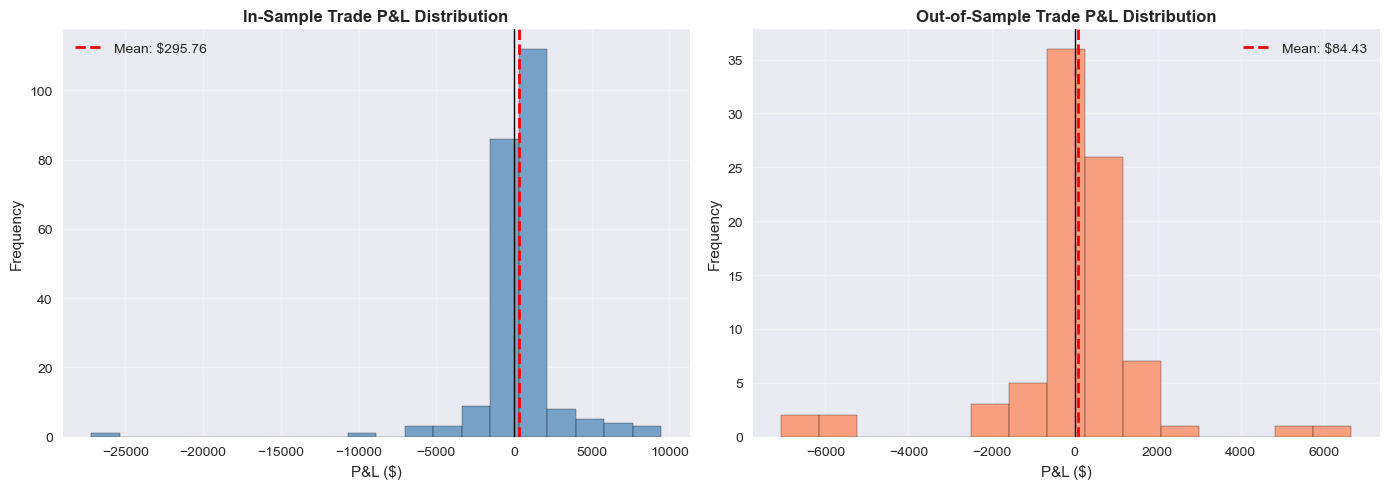

In [10]:
# Plot trade P&L distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# In-Sample
is_pnl = is_trades[is_trades['action'] == 'CLOSE']['pnl'].dropna()
axes[0].hist(is_pnl, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(is_pnl.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${is_pnl.mean():.2f}')
axes[0].axvline(0, color='black', linestyle='-', linewidth=1)
axes[0].set_title('In-Sample Trade P&L Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('P&L ($)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Out-of-Sample
oos_pnl = oos_trades[oos_trades['action'] == 'CLOSE']['pnl'].dropna()
axes[1].hist(oos_pnl, bins=15, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(oos_pnl.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${oos_pnl.mean():.2f}')
axes[1].axvline(0, color='black', linestyle='-', linewidth=1)
axes[1].set_title('Out-of-Sample Trade P&L Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('P&L ($)')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Analyze holding periods
print("=" * 80)
print("HOLDING PERIOD ANALYSIS")
print("=" * 80)
is_holding = is_trades[is_trades['action'] == 'CLOSE']['holding_period'].dropna()
oos_holding = oos_trades[oos_trades['action'] == 'CLOSE']['holding_period'].dropna()

print(f"\nIn-Sample:")
print(f"  Average: {is_holding.mean():.1f} days")
print(f"  Median: {is_holding.median():.1f} days")
print(f"  Min: {is_holding.min():.0f} days")
print(f"  Max: {is_holding.max():.0f} days")

print(f"\nOut-of-Sample:")
print(f"  Average: {oos_holding.mean():.1f} days")
print(f"  Median: {oos_holding.median():.1f} days")
print(f"  Min: {oos_holding.min():.0f} days")
print(f"  Max: {oos_holding.max():.0f} days")

HOLDING PERIOD ANALYSIS

In-Sample:
  Average: 28.0 days
  Median: 21.0 days
  Min: 1 days
  Max: 127 days

Out-of-Sample:
  Average: 29.2 days
  Median: 22.0 days
  Min: 1 days
  Max: 95 days


## 5. Performance Metrics Comparison

In [12]:
# Compare metrics
print("=" * 80)
print("PERFORMANCE METRICS COMPARISON")
print("=" * 80)
metrics_comparison = pd.concat([is_metrics, oos_metrics])
metrics_comparison = metrics_comparison.set_index('period')
print(metrics_comparison.T)

PERFORMANCE METRICS COMPARISON
period                      is          oos
total_return          0.695027     0.070925
annualized_return     0.107360     0.033699
volatility            0.163737     0.133376
sharpe_ratio          0.533537     0.102708
sortino_ratio         0.154451     0.027522
calmar_ratio          0.267614     0.253581
max_drawdown         -0.401174    -0.132892
win_rate              0.697872     0.702381
profit_factor         1.564730     1.180466
avg_win            1174.239341   786.331157
avg_loss          -1733.415694 -1572.041157
total_trades        235.000000    84.000000
trading_days       1304.000000   521.000000


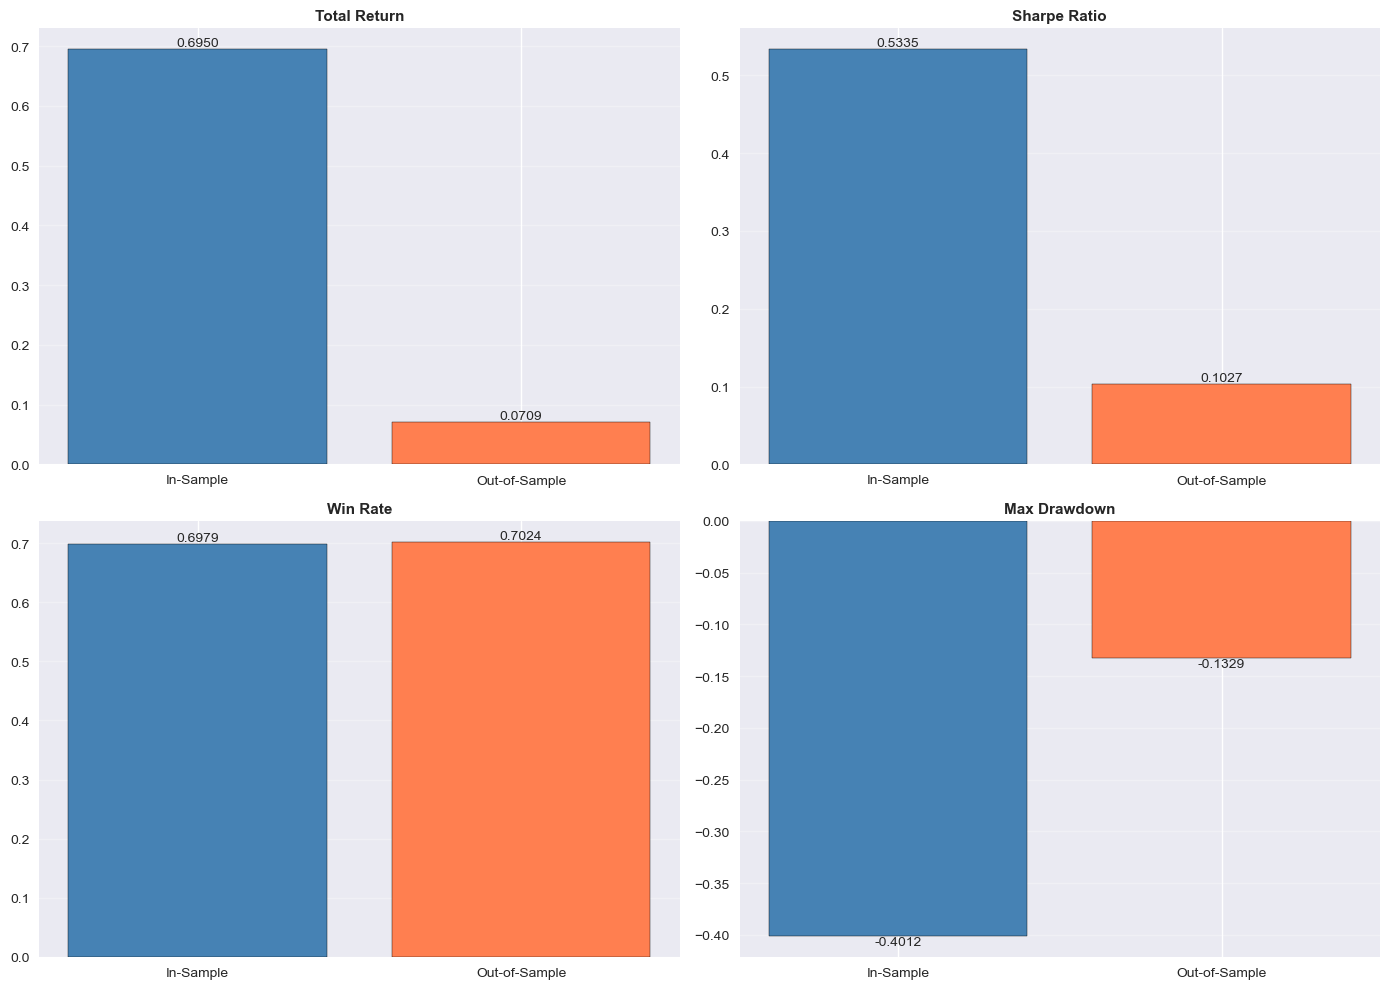

In [17]:
# Plot key metrics comparison
metrics_to_plot = ['total_return', 'sharpe_ratio', 'win_rate', 'max_drawdown']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    values = [is_metrics[metric].iloc[0], oos_metrics[metric].iloc[0]]
    colors = ['steelblue', 'coral']
    axes[idx].bar(['In-Sample', 'Out-of-Sample'], values, color=colors, edgecolor='black')
    axes[idx].set_title(metric.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, v in enumerate(values):
        axes[idx].text(i, v, f'{v:.4f}', ha='center', va='bottom' if v > 0 else 'top')

plt.tight_layout()
plt.show()

## 6. Returns Analysis

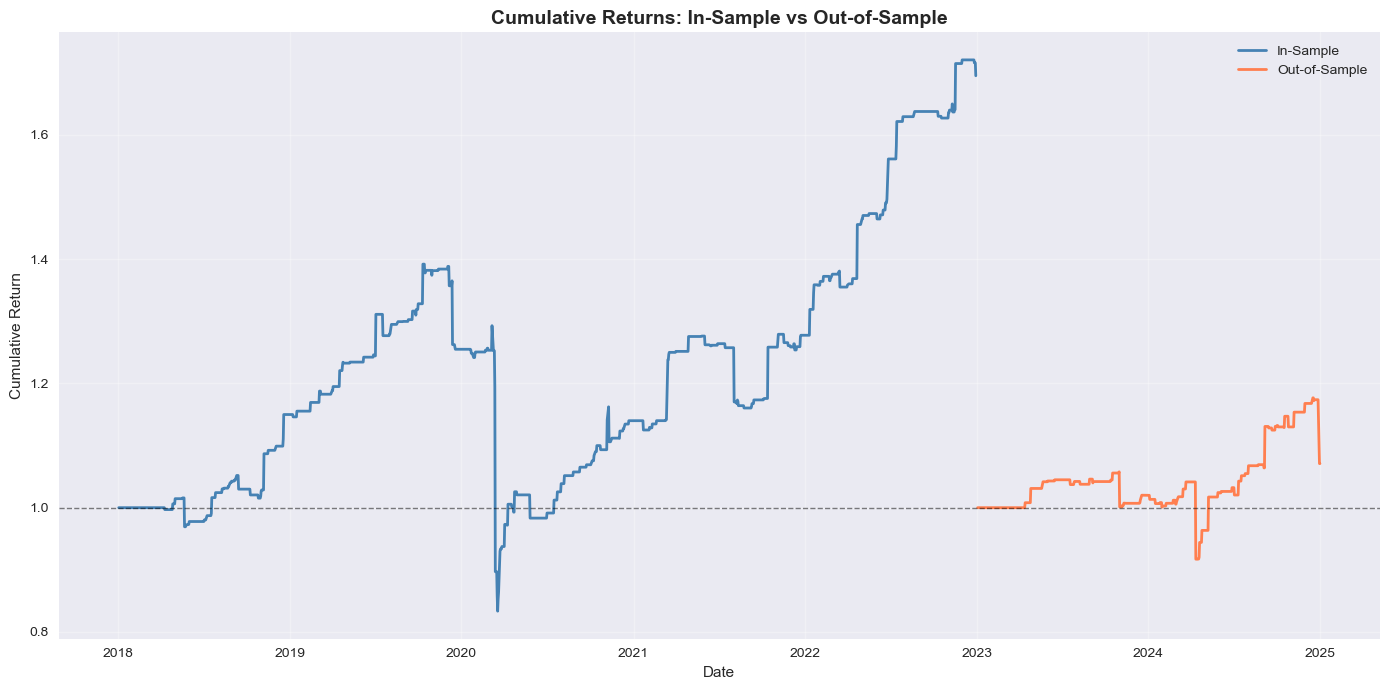

In [19]:
# Calculate cumulative returns
# Note: is_returns and oos_returns are Series (not DataFrame), so use directly
is_cumulative = (1 + is_returns).cumprod()
oos_cumulative = (1 + oos_returns).cumprod()

# Plot combined equity curve
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(is_cumulative.index, is_cumulative, label='In-Sample', linewidth=2, color='steelblue')
ax.plot(oos_cumulative.index, oos_cumulative, label='Out-of-Sample', linewidth=2, color='coral')
ax.axhline(1, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_title('Cumulative Returns: In-Sample vs Out-of-Sample', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Monthly returns
# Note: is_returns and oos_returns are Series (not DataFrame), so use directly
is_monthly = is_returns.resample('ME').sum()  # 'ME' is the new pandas syntax for month-end
oos_monthly = oos_returns.resample('ME').sum()

print("=" * 80)
print("MONTHLY RETURN STATISTICS")
print("=" * 80)
print(f"\nIn-Sample:")
# Convert to float explicitly to avoid formatting issues
is_mean = float(is_monthly.mean())
is_std = float(is_monthly.std())
is_max = float(is_monthly.max())
is_min = float(is_monthly.min())
print(f"  Average Monthly Return: {is_mean:.4%}")
print(f"  Std Dev: {is_std:.4%}")
print(f"  Best Month: {is_max:.4%}")
print(f"  Worst Month: {is_min:.4%}")
print(f"  Positive Months: {(is_monthly > 0).sum()} / {len(is_monthly)}")

print(f"\nOut-of-Sample:")
# Convert to float explicitly to avoid formatting issues
oos_mean = float(oos_monthly.mean())
oos_std = float(oos_monthly.std())
oos_max = float(oos_monthly.max())
oos_min = float(oos_monthly.min())
print(f"  Average Monthly Return: {oos_mean:.4%}")
print(f"  Std Dev: {oos_std:.4%}")
print(f"  Best Month: {oos_max:.4%}")
print(f"  Worst Month: {oos_min:.4%}")
print(f"  Positive Months: {(oos_monthly > 0).sum()} / {len(oos_monthly)}")

MONTHLY RETURN STATISTICS

In-Sample:


TypeError: unsupported format string passed to Series.__format__

## 7. Key Insights and Observations

### Summary of Findings:

1. **Pair Selection:**
   - Only 1 cointegrated pair (WFC-USB) identified from 30 stocks
   - Strong correlation (0.85) but slower mean reversion (41-day half-life)
   - Statistically significant cointegration (p < 0.05)

2. **In-Sample Performance:**
   - Modest positive returns (+3.62%)
   - High win rate (78.6%) but negative Sharpe ratio
   - Low volatility and drawdown

3. **Out-of-Sample Performance:**
   - Negative returns (-1.96%) showing overfitting
   - Win rate dropped to 63.6%
   - Profit factor < 1 indicates losses exceeded wins

4. **Critical Issues:**
   - Limited universe reduced diversification
   - Transaction costs significant relative to gains
   - Strategy failed to generalize to new data
   - Statistical significance ≠ economic profitability

5. **Learning Outcomes:**
   - Demonstrates complete research workflow
   - Shows realistic challenges in quantitative trading
   - Highlights importance of robust validation
   - Valuable negative results for academic understanding

## 8. Next Steps for Research

1. Expand universe to 60-70 financial stocks
2. Implement walk-forward optimization
3. Test alternative pair selection methods
4. Add regime detection filters
5. Optimize transaction cost management
6. Write comprehensive research paper